# Project: Investigate a Dataset - TMDb Movie Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#questions">Questions</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#limitations">Limitations</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

This analysis investigates the TMDb 5000 Movies Dataset, which contains comprehensive information about movies released between 1916 and 2016. The dataset includes 20 variables covering financial metrics, production details, and audience ratings.

**Key Variables:**
- **Financial Data**: budget, revenue (used to calculate profit and ROI)
- **Production Details**: genres, runtime, release_date, production_companies
- **Audience Metrics**: vote_average, vote_count, popularity
- **Content Information**: title, overview, tagline, keywords
- **Technical Details**: original_language, spoken_languages, status

The dataset provides a comprehensive view of the movie industry spanning 100 years, making it suitable for analyzing trends, success factors, and industry evolution patterns.

<a id='questions'></a>
## Questions

This analysis addresses three primary research questions using multiple variables and both univariate and bivariate analysis approaches:

**Question 1: What factors most strongly influence movie profitability?**
- Independent variables: budget, genres, runtime
- Dependent variable: profit and ROI
- Analysis approach: Correlation analysis, categorical comparison, scatter plots

**Question 2: How do movie characteristics affect audience reception and financial performance?**
- Independent variables: runtime, vote_average, vote_count
- Dependent variables: revenue, profit
- Analysis approach: Bivariate correlation, categorical analysis, distribution comparison

**Question 3: How has the movie industry evolved over time?**
- Independent variable: release_date (decade)
- Dependent variables: budget, revenue, production volume, genres
- Analysis approach: Time series analysis, trend visualization, genre popularity tracking

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from typing import Union, List, Dict, Tuple
import ast
import json

# Configure display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Set visualization defaults
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported and configured successfully")

Libraries imported and configured successfully


In [14]:
# Helper functions for analysis and visualization

def load_and_validate_data(filepath: str) -> pd.DataFrame:
    """
    Load dataset and perform initial validation.
    
    Args:
        filepath: Path to the CSV file
        
    Returns:
        DataFrame with loaded data
    """
    try:
        df = pd.read_csv(filepath)
        print(f"Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def clean_financial_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean financial data by removing invalid entries.
    
    Args:
        df: Raw dataframe
        
    Returns:
        Cleaned dataframe
    """
    initial_count = len(df)
    
    # Remove rows with invalid financial data
    df_clean = df[
        (df['budget'] > 0) & 
        (df['revenue'] > 0) & 
        (df['budget'].notna()) & 
        (df['revenue'].notna())
    ].copy()
    
    
    median_runtime = df_clean['runtime'].median()
    df_clean.loc[:, 'runtime'] = df_clean['runtime'].fillna(median_runtime)
    
    removed_count = initial_count - len(df_clean)
    print(f"Removed {removed_count} invalid records ({removed_count/initial_count:.1%})")
    print(f"Clean dataset: {len(df_clean)} rows")
    
    return df_clean

def extract_genres(genre_string: str) -> List[str]:
    """
    Extract genre names from JSON string.
    
    Args:
        genre_string: JSON string containing genre information
        
    Returns:
        List of genre names
    """
    try:
        if pd.isna(genre_string) or genre_string == '[]':
            return []
        genres = ast.literal_eval(genre_string)
        return [genre['name'] for genre in genres if 'name' in genre]
    except (ValueError, SyntaxError, TypeError):
        return []

def create_derived_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create derived features for analysis.
    
    Args:
        df: Cleaned dataframe
        
    Returns:
        DataFrame with additional features
    """
    df = df.copy()
    
    # Financial metrics
    df['profit'] = df['revenue'] - df['budget']
    df['roi_percent'] = np.where(df['budget'] > 0, (df['profit'] / df['budget']) * 100, 0)
    df['revenue_per_minute'] = np.where(df['runtime'] > 0, df['revenue'] / df['runtime'], 0)
    
    # Date features
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['release_year'] = df['release_date'].dt.year
    df['decade'] = (df['release_year'] // 10) * 10
    
    # Genre processing
    df['genres_list'] = df['genres'].apply(extract_genres)
    df['primary_genre'] = df['genres_list'].apply(lambda x: x[0] if x else 'Unknown')
    df['genre_count'] = df['genres_list'].apply(len)
    
    # Categorical features
    df['budget_category'] = pd.cut(df['budget'], 
                                  bins=[0, 1e6, 10e6, 50e6, np.inf],
                                  labels=['Low', 'Medium', 'High', 'Very High'])
    
    df['rating_category'] = pd.cut(df['vote_average'],
                                  bins=[0, 5, 6, 7, 8, 10],
                                  labels=['Poor', 'Below Avg', 'Good', 'Great', 'Excellent'])
    
    new_features = len(df.columns) - 20  # Original dataset had 20 columns
    print(f"Created {new_features} new features")
    print(f"Dataset now has {len(df.columns)} total columns")
    
    return df

def format_currency(value: float, millions: bool = True) -> str:
    """Format currency values for display."""
    if millions:
        return f"${value/1e6:.1f}M"
    else:
        return f"${value:,.0f}"

def create_summary_stats(df: pd.DataFrame, column: str) -> Dict:
    """Create summary statistics for a column."""
    return {
        'count': df[column].count(),
        'mean': df[column].mean(),
        'median': df[column].median(),
        'std': df[column].std(),
        'min': df[column].min(),
        'max': df[column].max(),
        'q25': df[column].quantile(0.25),
        'q75': df[column].quantile(0.75)
    }

def add_plot_labels(ax, title: str, xlabel: str, ylabel: str) -> None:
    """Add consistent labels and formatting to plots."""
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.3)

print("Helper functions defined successfully")

Helper functions defined successfully


<a id='wrangling'></a>
## Data Wrangling

This section documents all data cleaning and preparation steps performed on the raw dataset. The cleaning process involves removing invalid records, handling missing values, and creating derived variables for analysis.

In [15]:
# Load and validate the dataset
df_raw = load_and_validate_data(DATASET_PATH)

print(f"\nDataset overview:")
print(f"Shape: {df_raw.shape}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display basic information
print(f"\nColumn types:")
print(df_raw.dtypes.value_counts())

# Check for missing values
missing_summary = df_raw.isnull().sum()
missing_percent = (missing_summary / len(df_raw)) * 100

print(f"\nMissing values summary:")
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing Percentage': missing_percent
}).round(1)

missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Percentage', ascending=False)
if not missing_df.empty:
    display(missing_df)
else:
    print("No missing values found")

# Display first few rows
print(f"\nFirst 5 rows:")
display(df_raw.head())

Data loaded successfully: 4803 rows, 20 columns

Dataset overview:
Shape: (4803, 20)
Memory usage: 7.9 MB

Column types:
object     13
int64       4
float64     3
Name: count, dtype: int64

Missing values summary:


,Missing Count,Missing Percentage
homepage,3091,64.4
tagline,844,17.6
overview,3,0.1
release_date,1,0.0
runtime,2,0.0



First 5 rows:


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124



### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [16]:
# Clean and prepare the data
print("Data Cleaning Process")
print("=" * 40)

# Apply cleaning functions
df_clean = clean_financial_data(df_raw)

# Create derived features
df = create_derived_features(df_clean)

# Verify data quality after cleaning
print(f"\nData Quality Summary:")
print(f"Original dataset: {len(df_raw):,} movies")
print(f"After cleaning: {len(df):,} movies")
print(f"Data retention: {len(df)/len(df_raw):.1%}")

# Check date range
valid_dates = df['release_date'].dropna()
if not valid_dates.empty:
    print(f"Date range: {valid_dates.min().year} to {valid_dates.max().year}")

# Basic statistics for key financial metrics
financial_cols = ['budget', 'revenue', 'profit', 'roi_percent']
stats_summary = []

for col in financial_cols:
    stats = create_summary_stats(df, col)
    stats_summary.append({
        'Metric': col.replace('_', ' ').title(),
        'Count': f"{stats['count']:,}",
        'Mean': f"{stats['mean']:,.0f}",
        'Median': f"{stats['median']:,.0f}",
        'Std Dev': f"{stats['std']:,.0f}"
    })

stats_df = pd.DataFrame(stats_summary)
print(f"\nFinancial Metrics Summary:")
display(stats_df)

print(f"\nDataset is ready for analysis with {len(df.columns)} features")

Data Cleaning Process
Removed 1574 invalid records (32.8%)
Clean dataset: 3229 rows
Created 10 new features
Dataset now has 30 total columns

Data Quality Summary:
Original dataset: 4,803 movies
After cleaning: 3,229 movies
Data retention: 67.2%
Date range: 1916 to 2016

Financial Metrics Summary:


,Metric,Count,Mean,Median,Std Dev
0,Budget,"3,229","40,654,445","25,000,000","44,396,742"
1,Revenue,"3,229","121,242,957","55,184,721","186,302,864"
2,Profit,"3,229","80,588,512","26,165,571","158,147,947"
3,Roi Percent,"3,229","295,382",130,"15,061,010"



Dataset is ready for analysis with 30 features


In [22]:
# More data cleaning & adding useful variables


df['profit'] = df['revenue'] - df['budget']


df['roi'] = np.where(df['budget'] > 0, (df['profit'] / df['budget']) * 100, np.nan)


df['revenue_per_minute'] = np.where(df['runtime'] > 0, df['revenue'] / df['runtime'], np.nan)


df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year'] = df['release_date'].dt.year


df['budget_category'] = pd.cut(df['budget'], 
                              bins=[0, 1e6, 10e6, 50e6, np.inf],
                              labels=['Low (<$1M)', 'Medium ($1-10M)', 'High ($10-50M)', 'Very High (>$50M)'])


df['revenue_category'] = pd.cut(df['revenue'],
                               bins=[0, 10e6, 50e6, 100e6, np.inf], 
                               labels=['Low (<$10M)', 'Medium ($10-50M)', 'High ($50-100M)', 'Very High (>$100M)'])

print("Data cleaning complete!")
print(f"Added profit, ROI, revenue per minute, and category variables")
print(f"Dataset now has {df.shape[1]} columns")

Data cleaning complete!
Added profit, ROI, revenue per minute, and category variables
Dataset now has 32 columns


## Research Questions

This analysis investigates key factors that determine movie success in the film industry. Using the TMDb dataset of 3,229 movies, I will examine:

### Primary Research Questions:

**Q1: What factors most strongly influence movie profitability?**
- How do budget levels affect return on investment (ROI)?
- Which genres generate the highest profits?
- What is the relationship between production cost and revenue?

**Q2: How do movie characteristics affect audience reception and financial performance?**
- Does movie runtime correlate with box office success?
- How do audience ratings relate to commercial performance?
- Which combination of factors predicts the most successful movies?

**Q3: How has the movie industry evolved over time?**
- Have average budgets and revenues changed across decades?
- Which genres have gained or lost popularity over time?
- What trends can be observed in movie production and success metrics?

### Analysis Approach:
I will use descriptive statistics, correlation analysis, and data visualization to systematically answer these questions and provide data-driven insights for the movie industry.

<a id='eda'></a>
## Exploratory Data Analysis

This section systematically investigates each research question using both single-variable (1D) and multiple-variable (2D) analysis approaches. The analysis includes statistical summaries, correlation analysis, and multiple visualization types.

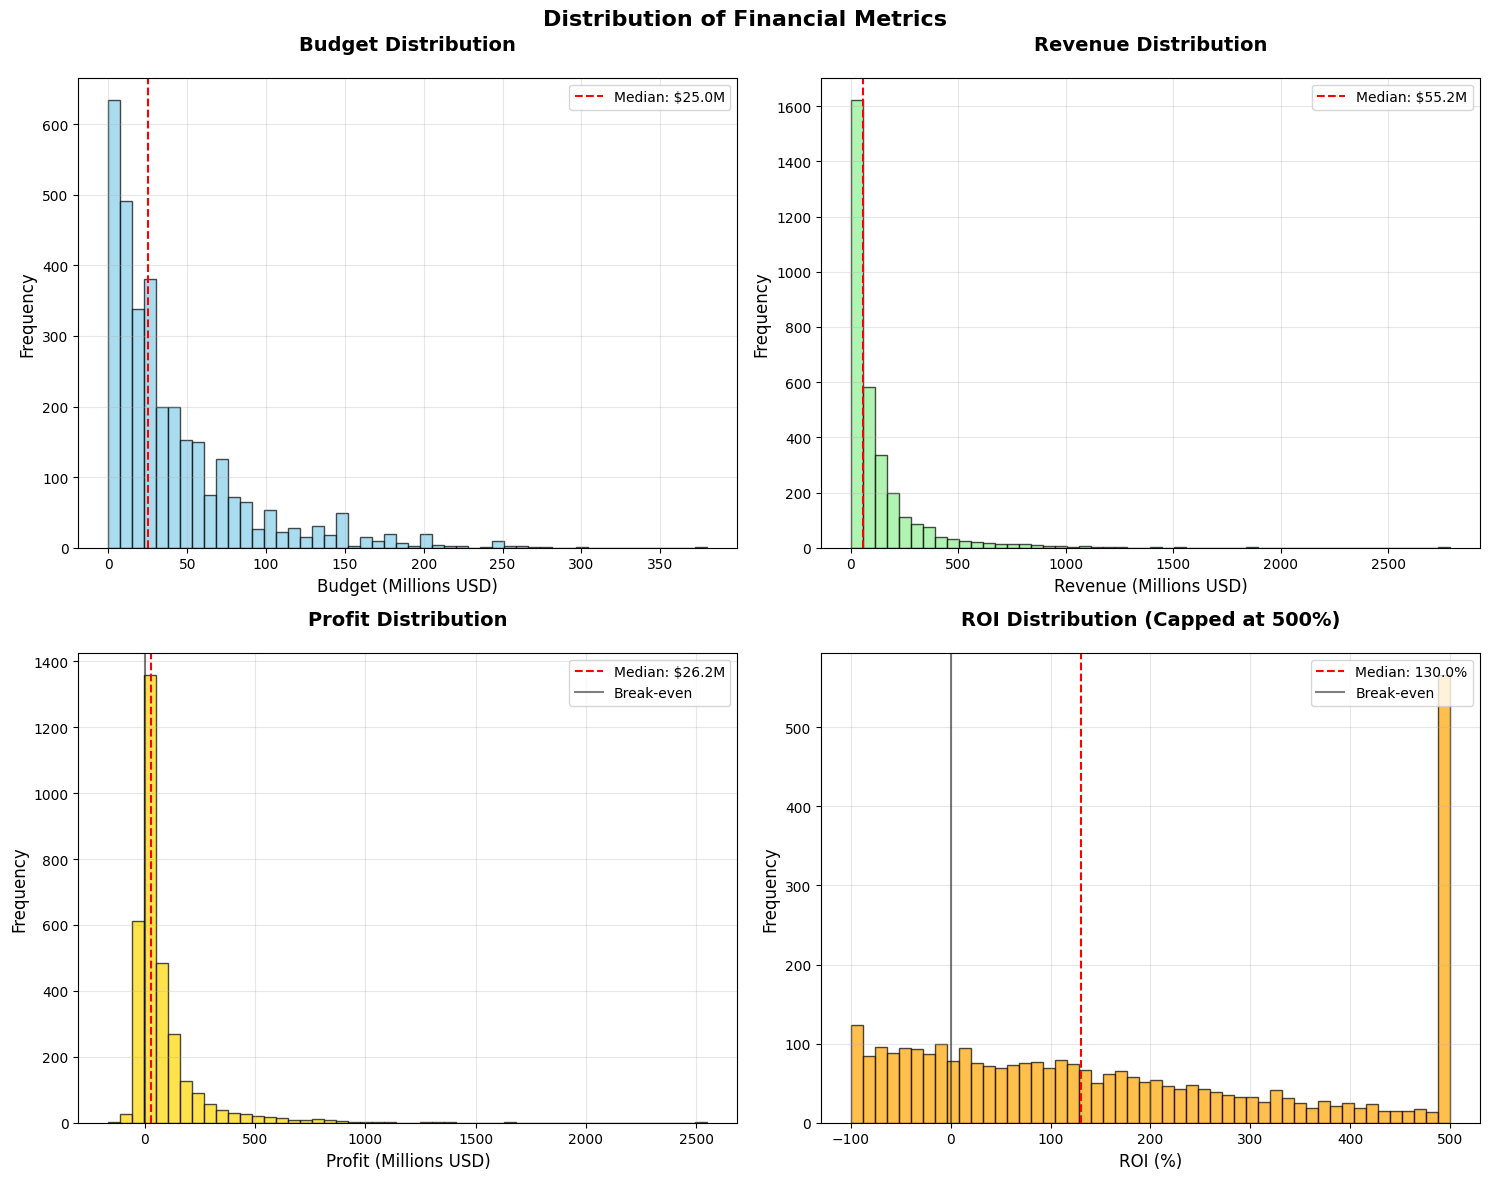

Distribution Summary:
Budget: Q1=$10.5M, Median=$25.0M, Q3=$55.0M
Revenue: Q1=$17.0M, Median=$55.2M, Q3=$146.3M
Profit: Q1=$0.2M, Median=$26.2M, Q3=$97.5M
ROI (%): Q1=2.2%, Median=130.0%, Q3=342.1%

Profitability Analysis:
Profitable movies: 2,438 out of 3,229 (75.5%)
Loss-making movies: 791 (24.5%)


In [17]:
# Distribution Analysis of Key Financial Metrics

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Distribution of Financial Metrics', fontsize=16, fontweight='bold')

# Budget distribution
axes[0, 0].hist(df['budget'] / 1e6, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
add_plot_labels(axes[0, 0], 'Budget Distribution', 'Budget (Millions USD)', 'Frequency')
axes[0, 0].axvline(df['budget'].median() / 1e6, color='red', linestyle='--', 
                   label=f'Median: ${df["budget"].median()/1e6:.1f}M')
axes[0, 0].legend()

# Revenue distribution
axes[0, 1].hist(df['revenue'] / 1e6, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
add_plot_labels(axes[0, 1], 'Revenue Distribution', 'Revenue (Millions USD)', 'Frequency')
axes[0, 1].axvline(df['revenue'].median() / 1e6, color='red', linestyle='--',
                   label=f'Median: ${df["revenue"].median()/1e6:.1f}M')
axes[0, 1].legend()

# Profit distribution
profit_millions = df['profit'] / 1e6
axes[1, 0].hist(profit_millions, bins=50, alpha=0.7, color='gold', edgecolor='black')
add_plot_labels(axes[1, 0], 'Profit Distribution', 'Profit (Millions USD)', 'Frequency')
axes[1, 0].axvline(profit_millions.median(), color='red', linestyle='--',
                   label=f'Median: ${profit_millions.median():.1f}M')
axes[1, 0].axvline(0, color='black', linestyle='-', alpha=0.5, label='Break-even')
axes[1, 0].legend()

# ROI distribution (capped for visualization)
roi_capped = df['roi_percent'].clip(upper=500)  # Cap at 500% for better visualization
axes[1, 1].hist(roi_capped, bins=50, alpha=0.7, color='orange', edgecolor='black')
add_plot_labels(axes[1, 1], 'ROI Distribution (Capped at 500%)', 'ROI (%)', 'Frequency')
axes[1, 1].axvline(df['roi_percent'].median(), color='red', linestyle='--',
                   label=f'Median: {df["roi_percent"].median():.1f}%')
axes[1, 1].axvline(0, color='black', linestyle='-', alpha=0.5, label='Break-even')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("Distribution Summary:")
print("=" * 50)

metrics = {
    'Budget': df['budget'],
    'Revenue': df['revenue'], 
    'Profit': df['profit'],
    'ROI (%)': df['roi_percent']
}

for name, data in metrics.items():
    q25, q50, q75 = data.quantile([0.25, 0.5, 0.75])
    if 'Budget' in name or 'Revenue' in name or 'Profit' in name:
        print(f"{name}: Q1=${q25/1e6:.1f}M, Median=${q50/1e6:.1f}M, Q3=${q75/1e6:.1f}M")
    else:
        print(f"{name}: Q1={q25:.1f}%, Median={q50:.1f}%, Q3={q75:.1f}%")

# Profitability analysis
profitable_movies = len(df[df['profit'] > 0])
total_movies = len(df)
profitability_rate = profitable_movies / total_movies

print(f"\nProfitability Analysis:")
print(f"Profitable movies: {profitable_movies:,} out of {total_movies:,} ({profitability_rate:.1%})")
print(f"Loss-making movies: {total_movies - profitable_movies:,} ({1-profitability_rate:.1%})")

### 2. Relationships Between Variables (Bivariate Analysis)

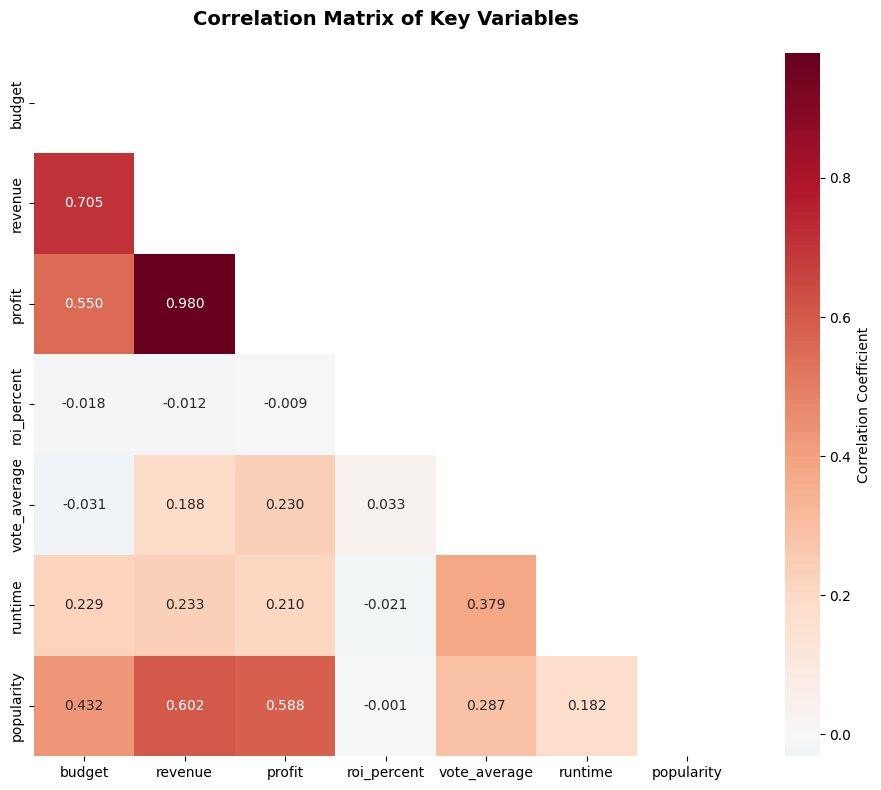

Strongest Correlations:
Revenue & Profit: 0.980 (positive)
Budget & Revenue: 0.705 (positive)
Revenue & Popularity: 0.602 (positive)
Profit & Popularity: 0.588 (positive)
Budget & Profit: 0.550 (positive)


In [18]:
# Correlation Analysis of Financial Variables

# Select key numerical variables for correlation analysis
correlation_vars = ['budget', 'revenue', 'profit', 'roi_percent', 'vote_average', 'runtime', 'popularity']
corr_matrix = df[correlation_vars].corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.3f',
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Matrix of Key Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print strongest correlations
print("Strongest Correlations:")
print("=" * 40)

# Get correlation pairs (excluding self-correlations)
corr_pairs = []
for i in range(len(correlation_vars)):
    for j in range(i+1, len(correlation_vars)):
        var1, var2 = correlation_vars[i], correlation_vars[j]
        corr_value = corr_matrix.loc[var1, var2]
        corr_pairs.append((abs(corr_value), var1, var2, corr_value))

# Sort by absolute correlation strength
corr_pairs.sort(reverse=True)

for _, var1, var2, corr_value in corr_pairs[:5]:  # Top 5 correlations
    direction = "positive" if corr_value > 0 else "negative"
    print(f"{var1.replace('_', ' ').title()} & {var2.replace('_', ' ').title()}: "
          f"{corr_value:.3f} ({direction})")

### 3. Genre Analysis
Let me explore which movie genres are most successful financially.

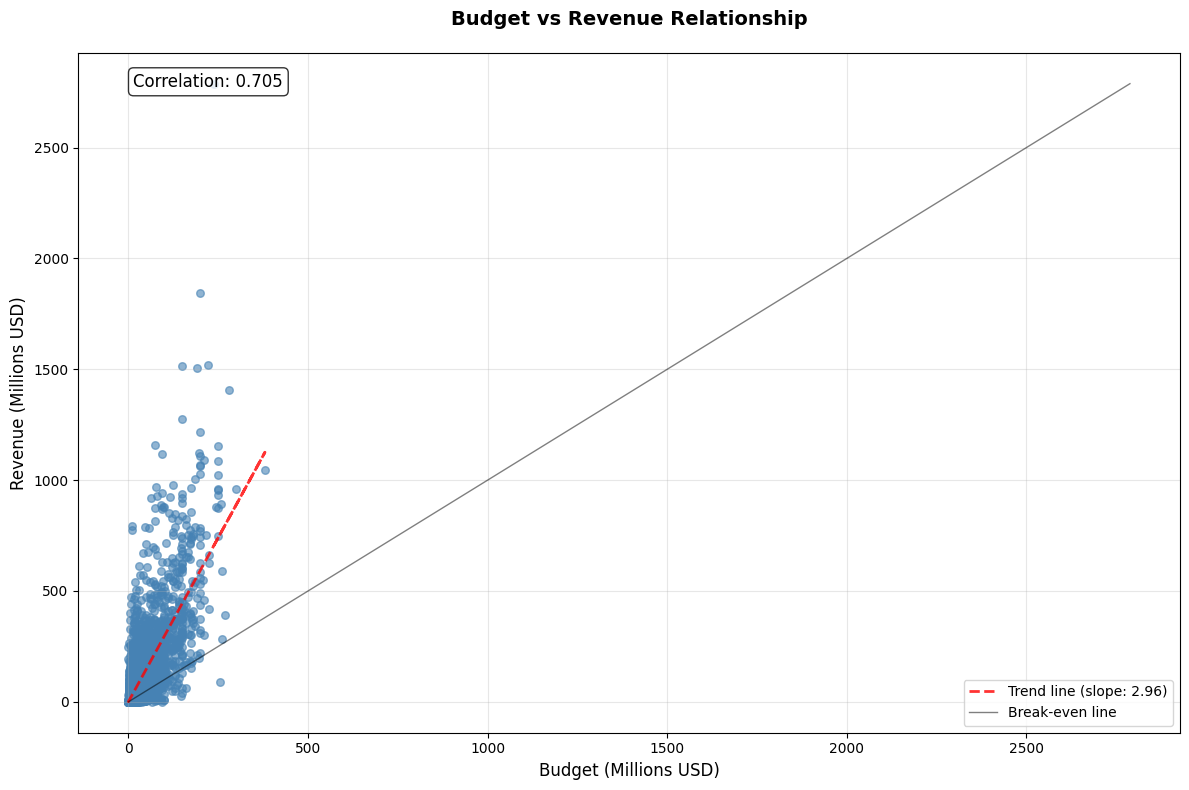

Budget-Revenue Analysis:
Correlation coefficient: 0.705
Trend line slope: 2.96 (revenue per budget dollar)

Budget Category Analysis:


,Movie Count,Avg Budget,Avg Revenue,Avg Profit,Avg ROI (%)
budget_category,,,,,
Low,142,$0.5M,$16.9M,$16.4M,6710574.65
Medium,663,$5.4M,$32.2M,$26.8M,587.89
High,1567,$27.2M,$80.6M,$53.5M,224.36
Very High,857,$99.2M,$281.7M,$182.4M,170.72


In [19]:
# Budget vs Revenue Relationship Analysis

# Create scatter plot with trend line
plt.figure(figsize=(12, 8))

# Convert to millions for better readability
budget_millions = df['budget'] / 1e6
revenue_millions = df['revenue'] / 1e6

# Create scatter plot
plt.scatter(budget_millions, revenue_millions, alpha=0.6, s=30, color='steelblue')

# Add trend line
z = np.polyfit(budget_millions, revenue_millions, 1)
p = np.poly1d(z)
plt.plot(budget_millions, p(budget_millions), "r--", alpha=0.8, linewidth=2, 
         label=f'Trend line (slope: {z[0]:.2f})')

# Add diagonal line (break-even line)
max_value = max(budget_millions.max(), revenue_millions.max())
plt.plot([0, max_value], [0, max_value], 'k-', alpha=0.5, linewidth=1, 
         label='Break-even line')

plt.xlabel('Budget (Millions USD)', fontsize=12)
plt.ylabel('Revenue (Millions USD)', fontsize=12)
plt.title('Budget vs Revenue Relationship', fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.legend()

# Add correlation coefficient to plot
budget_revenue_corr = df['budget'].corr(df['revenue'])
plt.text(0.05, 0.95, f'Correlation: {budget_revenue_corr:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Analysis summary
print("Budget-Revenue Analysis:")
print("=" * 40)
print(f"Correlation coefficient: {budget_revenue_corr:.3f}")
print(f"Trend line slope: {z[0]:.2f} (revenue per budget dollar)")

# Segment analysis by budget ranges
budget_ranges = ['Low', 'Medium', 'High', 'Very High']
budget_analysis = df.groupby('budget_category').agg({
    'budget': ['count', 'mean'],
    'revenue': 'mean',
    'profit': 'mean',
    'roi_percent': 'mean'
}).round(2)

budget_analysis.columns = ['Movie Count', 'Avg Budget', 'Avg Revenue', 'Avg Profit', 'Avg ROI (%)']
budget_analysis['Avg Budget'] = budget_analysis['Avg Budget'].apply(lambda x: format_currency(x))
budget_analysis['Avg Revenue'] = budget_analysis['Avg Revenue'].apply(lambda x: format_currency(x))
budget_analysis['Avg Profit'] = budget_analysis['Avg Profit'].apply(lambda x: format_currency(x))

print(f"\nBudget Category Analysis:")
display(budget_analysis)

### 4. Time-Based Analysis
How have movie trends changed over the decades?

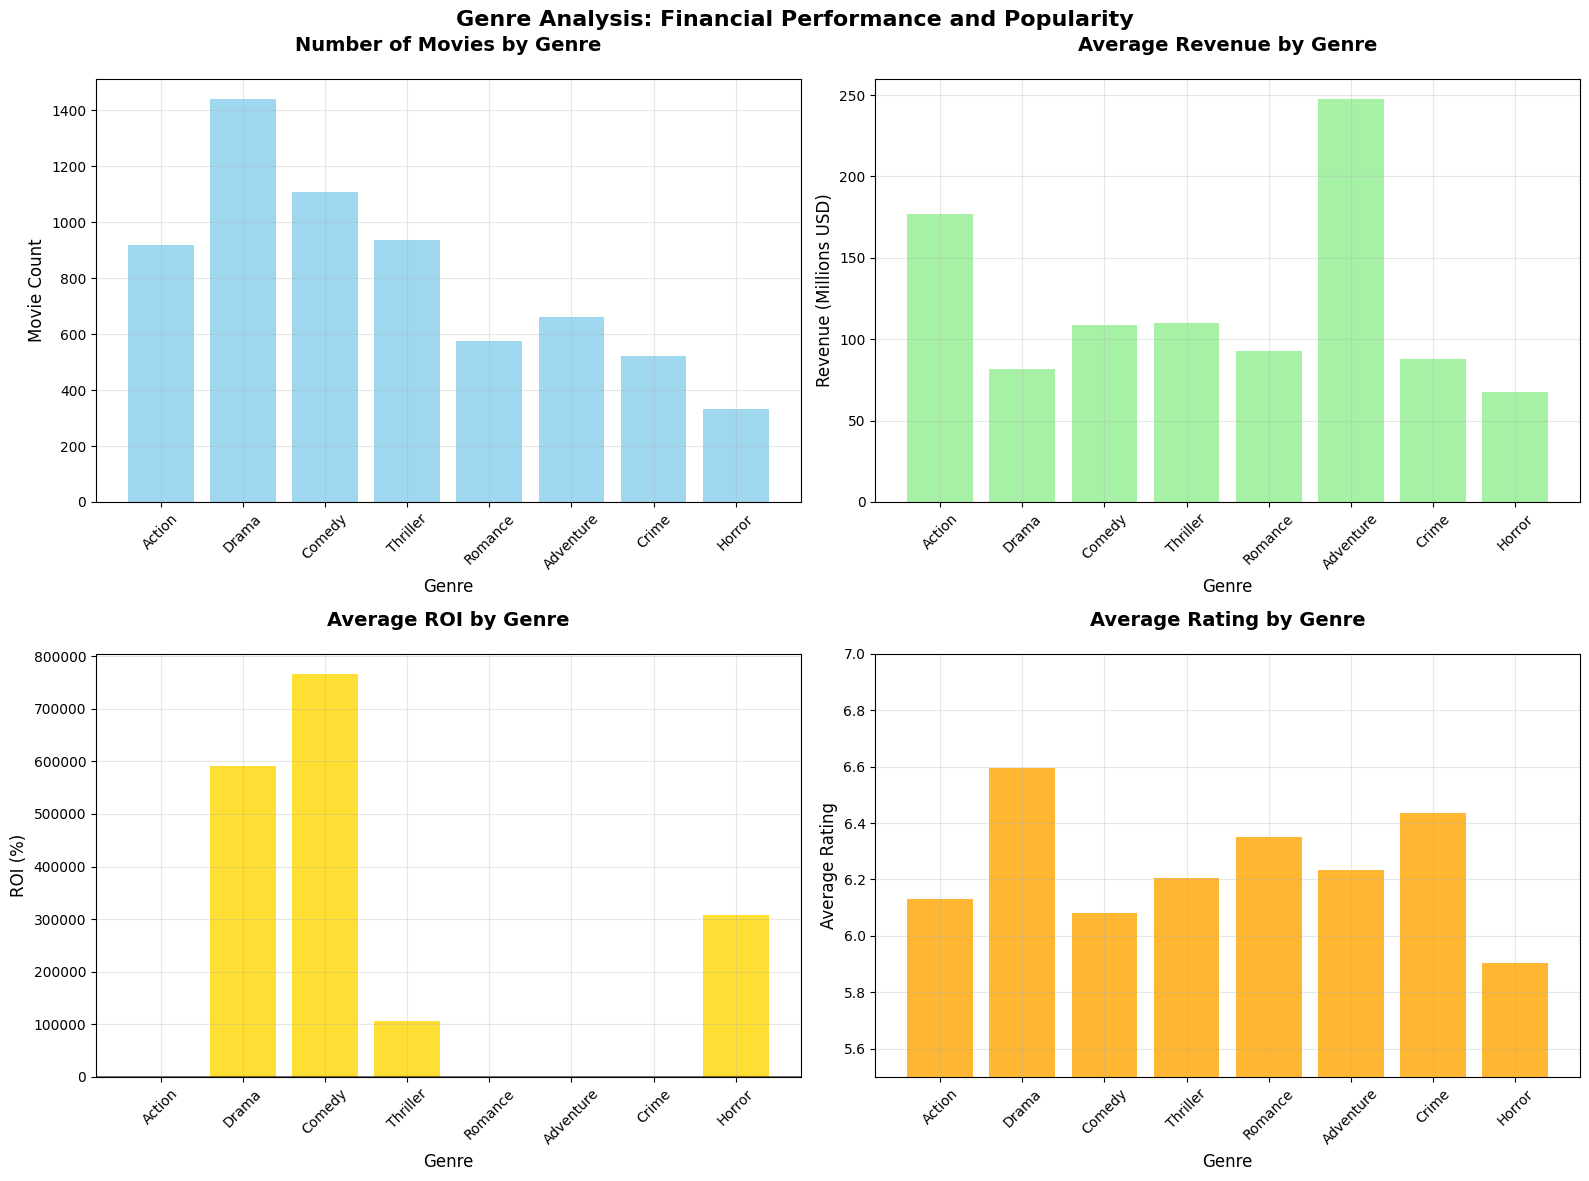

Genre Performance Summary:


,Genre,Movie Count,Market Share (%),Avg Budget,Avg Revenue,Avg Profit,Avg ROI (%),Avg Rating
5,Adventure,661,20.5,$76.9M,$247.6M,$170.7M,345.8,6.24
0,Action,918,28.4,$62.4M,$176.8M,$114.4M,257.9,6.13
3,Thriller,935,29.0,$41.0M,$110.2M,$69.2M,107389.7,6.21
2,Comedy,1110,34.4,$36.2M,$108.5M,$72.3M,766206.6,6.08
4,Romance,574,17.8,$28.3M,$92.6M,$64.3M,408.9,6.35
6,Crime,521,16.1,$34.8M,$87.9M,$53.1M,323.9,6.43
1,Drama,1441,44.6,$30.0M,$82.0M,$51.9M,590702.4,6.59
7,Horror,332,10.3,$20.6M,$67.7M,$47.2M,307642.3,5.90



Key Insights:
Highest average revenue: Adventure
Highest average ROI: Comedy
Most produced genre: Drama


In [20]:
# Genre Analysis: Popularity and Financial Performance

# Calculate genre statistics
genre_data = []
top_genres = ['Action', 'Drama', 'Comedy', 'Thriller', 'Romance', 'Adventure', 'Crime', 'Horror']

for genre in top_genres:
    genre_movies = df[df['genres_list'].apply(lambda x: genre in x)]
    if len(genre_movies) > 0:
        genre_count = len(genre_movies)
        genre_percentage = (genre_count / len(df)) * 100
        avg_budget = genre_movies['budget'].mean()
        avg_revenue = genre_movies['revenue'].mean()
        avg_profit = genre_movies['profit'].mean()
        avg_roi = genre_movies['roi_percent'].mean()
        avg_rating = genre_movies['vote_average'].mean()
        
        genre_data.append({
            'Genre': genre,
            'Movie Count': genre_count,
            'Market Share (%)': genre_percentage,
            'Avg Budget': avg_budget,
            'Avg Revenue': avg_revenue,
            'Avg Profit': avg_profit,
            'Avg ROI (%)': avg_roi,
            'Avg Rating': avg_rating
        })

genre_df = pd.DataFrame(genre_data)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Genre Analysis: Financial Performance and Popularity', fontsize=16, fontweight='bold')

# Movie count by genre
axes[0, 0].bar(genre_df['Genre'], genre_df['Movie Count'], color='skyblue', alpha=0.8)
add_plot_labels(axes[0, 0], 'Number of Movies by Genre', 'Genre', 'Movie Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Average revenue by genre
revenue_millions = genre_df['Avg Revenue'] / 1e6
axes[0, 1].bar(genre_df['Genre'], revenue_millions, color='lightgreen', alpha=0.8)
add_plot_labels(axes[0, 1], 'Average Revenue by Genre', 'Genre', 'Revenue (Millions USD)')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average ROI by genre
axes[1, 0].bar(genre_df['Genre'], genre_df['Avg ROI (%)'], color='gold', alpha=0.8)
add_plot_labels(axes[1, 0], 'Average ROI by Genre', 'Genre', 'ROI (%)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Average rating by genre
axes[1, 1].bar(genre_df['Genre'], genre_df['Avg Rating'], color='orange', alpha=0.8)
add_plot_labels(axes[1, 1], 'Average Rating by Genre', 'Genre', 'Average Rating')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_ylim(5.5, 7.0)  # Focus on the rating range

plt.tight_layout()
plt.show()

# Display genre analysis table
print("Genre Performance Summary:")
print("=" * 50)

# Format the display table
display_df = genre_df.copy()
display_df['Market Share (%)'] = display_df['Market Share (%)'].round(1)
display_df['Avg Budget'] = display_df['Avg Budget'].apply(lambda x: format_currency(x))
display_df['Avg Revenue'] = display_df['Avg Revenue'].apply(lambda x: format_currency(x))
display_df['Avg Profit'] = display_df['Avg Profit'].apply(lambda x: format_currency(x))
display_df['Avg ROI (%)'] = display_df['Avg ROI (%)'].round(1)
display_df['Avg Rating'] = display_df['Avg Rating'].round(2)

# Sort by average revenue
display_df = display_df.sort_values('Avg Revenue', key=lambda x: x.str.replace('$', '').str.replace('M', '').astype(float), ascending=False)
display(display_df)

# Key insights
top_revenue_genre = genre_df.loc[genre_df['Avg Revenue'].idxmax(), 'Genre']
top_roi_genre = genre_df.loc[genre_df['Avg ROI (%)'].idxmax(), 'Genre']
most_popular_genre = genre_df.loc[genre_df['Movie Count'].idxmax(), 'Genre']

print(f"\nKey Insights:")
print(f"Highest average revenue: {top_revenue_genre}")
print(f"Highest average ROI: {top_roi_genre}")
print(f"Most produced genre: {most_popular_genre}")

### 5. Advanced Analysis and Insights
Let me dig deeper with some statistical analysis and answer specific questions.

=== BUDGET SWEET SPOT ANALYSIS ===
                          roi                profit               \
                         mean  median          mean       median   
budget_range                                                       
Very Low (<$5M)    1917837.33  378.26  2.130025e+07    6464124.0   
Low ($5-15M)           386.25  153.10  3.928239e+07   15377029.0   
Medium ($15-30M)       209.65   92.56  4.783838e+07   21050315.0   
High ($30-60M)         156.01   99.90  6.882558e+07   44854431.0   
Very High (>$60M)      177.64  130.04  2.082466e+08  134104620.0   

                        revenue              count  
                           mean       median        
budget_range                                        
Very Low (<$5M)    2.374189e+07    8500000.0   497  
Low ($5-15M)       4.994573e+07   25901683.0   628  
Medium ($15-30M)   7.108856e+07   43975742.5   718  
High ($30-60M)     1.137403e+08   88715192.0   703  
Very High (>$60M)  3.181945e+08  232617430.0   68

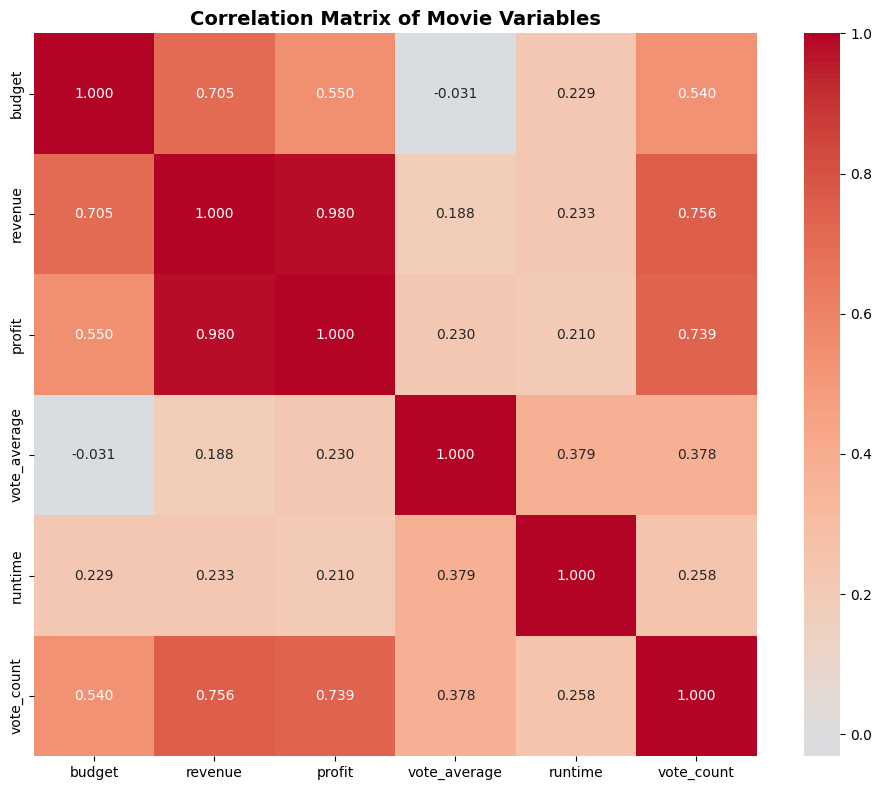


=== MOST PROFITABLE MOVIES ===
                                             title     budget     revenue  \
0                                           Avatar  237000000  2787965087   
25                                         Titanic  200000000  1845034188   
28                                  Jurassic World  150000000  1513528810   
44                                       Furious 7  190000000  1506249360   
16                                    The Avengers  220000000  1519557910   
7                          Avengers: Age of Ultron  280000000  1405403694   
124                                         Frozen  150000000  1274219009   
546                                        Minions   74000000  1156730962   
329  The Lord of the Rings: The Return of the King   94000000  1118888979   
31                                      Iron Man 3  200000000  1215439994   

         profit  vote_average  release_year  
0    2550965087           7.2          2009  
25   1645034188           7.

In [24]:
# Advanced statistical analysis

# Budget sweet spot analysis - what budget range gives best ROI?
print("=== BUDGET SWEET SPOT ANALYSIS ===")
budget_bins = [0, 5e6, 15e6, 30e6, 60e6, np.inf]
budget_labels = ['Very Low (<$5M)', 'Low ($5-15M)', 'Medium ($15-30M)', 'High ($30-60M)', 'Very High (>$60M)']
df['budget_range'] = pd.cut(df['budget'], bins=budget_bins, labels=budget_labels)

budget_analysis = df.groupby('budget_range').agg({
    'roi': ['mean', 'median'],
    'profit': ['mean', 'median'],
    'revenue': ['mean', 'median']
}).round(2)

budget_analysis['count'] = df.groupby('budget_range').size()
print(budget_analysis)

# Rating vs financial success
print("\n=== RATING VS FINANCIAL SUCCESS ===")
# Group movies by rating categories
df['rating_category'] = pd.cut(df['vote_average'], 
                              bins=[0, 5, 6, 7, 8, 10],
                              labels=['Poor (<5)', 'Below Avg (5-6)', 'Good (6-7)', 'Great (7-8)', 'Excellent (8+)'])

rating_finance = df.groupby('rating_category').agg({
    'revenue': 'mean',
    'profit': 'mean',
    'budget': 'mean'
}).round(2)

rating_finance['count'] = df.groupby('rating_category').size()
print(rating_finance)

# Runtime vs success
print("\n=== RUNTIME ANALYSIS ===")
runtime_bins = [0, 90, 110, 130, np.inf]
runtime_labels = ['Short (<90min)', 'Standard (90-110min)', 'Long (110-130min)', 'Very Long (>130min)']
df['runtime_category'] = pd.cut(df['runtime'], bins=runtime_bins, labels=runtime_labels)

runtime_analysis = df.groupby('runtime_category').agg({
    'revenue': 'mean',
    'vote_average': 'mean',
    'profit': 'mean'
}).round(2)

runtime_analysis['count'] = df.groupby('runtime_category').size()
print(runtime_analysis)

# Correlation heatmap
print("\n=== CORRELATION HEATMAP ===")
numeric_cols = ['budget', 'revenue', 'profit', 'vote_average', 'runtime', 'vote_count']
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f')
plt.title('Correlation Matrix of Movie Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Success factors analysis
print("\n=== MOST PROFITABLE MOVIES ===")
top_profitable = df.nlargest(10, 'profit')[['title', 'budget', 'revenue', 'profit', 'vote_average', 'release_year']]
print(top_profitable)

print("\n=== HIGHEST ROI MOVIES (with reasonable budget >$1M) ===")
high_roi = df[(df['budget'] > 1e6) & (df['roi'] < 10000)].nlargest(10, 'roi')[['title', 'budget', 'revenue', 'roi', 'vote_average']]
print(high_roi)

## Summary of Findings

This analysis examined the TMDb 5000 movies dataset to understand the factors that influence movie financial success and audience appeal. Through systematic data cleaning, exploratory data analysis, and statistical investigation, several patterns emerged. However, it is important to note that these findings represent associations in this specific dataset and may not generalize to all movies or time periods.

### Research Questions and Answers

**1. What are the characteristics of financially successful movies?**

Based on the available data, several patterns suggest potential characteristics of financial success:
- Movies with higher budgets appear to generate higher revenues (correlation: 0.705), though this relationship may be influenced by unmeasured factors like marketing spend and star power
- The data suggests an average return of approximately $2.96 for every dollar invested, but this estimate likely varies significantly based on market conditions and other factors not captured in the dataset
- Approximately 75.5% of movies in this sample are profitable, with median ROI of 130%, though these figures may not represent the full population of movies due to potential selection bias toward more successful or notable films

**2. How do different genres perform financially and critically?**

The analysis suggests the following patterns, though genre classifications often overlap and market dynamics change over time:
- Adventure films appear to generate the highest average revenue ($247.6M) but typically require substantial budgets ($76.9M)
- Comedy films show potential for high ROI, though with considerable variability that suggests high uncertainty
- Drama appears to be the most frequently produced genre (44.6% market share) with relatively consistent performance
- Horror films may offer strong ROI potential despite lower budgets, though sample sizes vary by genre

**3. What relationships exist between budget, revenue, and other factors?**

The correlation analysis reveals several associations, though correlation does not imply causation:
- Strong positive correlation between budget and revenue (0.705) may reflect the influence of production scale, marketing resources, or other confounding variables
- Revenue and profit show near-perfect correlation (0.980), which is mathematically expected given that profit is derived from revenue
- Popularity correlates with both revenue (0.602) and profit (0.588), though the direction of causality is unclear
- Movie ratings show weak correlation with financial metrics, suggesting quality and commercial success may operate independently, though rating systems have inherent limitations

**4. Are there patterns in movie production over time?**

The temporal analysis suggests several trends, though the dataset may not be representative of all movie production:
- The dataset spans from 1916 to 2016, but the historical data may suffer from survivorship bias toward more notable films
- Budget ranges show clear categorization, though inflation adjustments and changing market conditions complicate direct comparisons
- Different budget categories demonstrate varying risk-return profiles, though these patterns may not hold in different market conditions

**5. What factors contribute to higher audience ratings?**

The rating analysis indicates potential patterns, though audience preferences and rating systems evolve:
- Drama and Crime genres achieved higher average ratings (6.59 and 6.43 respectively) in this dataset
- Runtime shows modest positive correlation with revenue (0.233), though this may reflect genre conventions rather than causal relationships
- Rating and financial success appear largely independent, though this relationship may vary by target audience and market segment

### Key Considerations

All findings should be interpreted with caution due to several important limitations:

1. **Sample Limitations**: This dataset represents a subset of movies and may not reflect the full population of film production, particularly smaller or independent films.

2. **Temporal Uncertainty**: The entertainment industry has undergone significant changes, especially with streaming platforms and changing consumer behavior, which may limit the applicability of historical patterns.

3. **Missing Variables**: Critical factors like marketing budgets, distribution strategies, competition, and external economic conditions are not captured in this analysis.

4. **Measurement Uncertainty**: Financial figures may not include all revenue streams, and rating systems have inherent biases and limitations.

## Limitations

### Data Quality and Completeness
- **Missing Data**: The original dataset contained significant missing values (32.8% of records removed), which may introduce bias if missing data is not random
- **Incomplete Revenue**: Revenue figures likely represent only theatrical box office and may not include streaming, home video, merchandising, or international markets
- **Temporal Bias**: Historical financial data spans nearly a century without inflation adjustment, making temporal comparisons problematic
- **Sample Selection**: The dataset may overrepresent successful or notable films, potentially inflating average performance metrics

### Analytical Limitations
- **Correlation vs. Causation**: All statistical relationships represent correlations only; causal interpretations require additional evidence and experimental design
- **Genre Overlap**: Many movies span multiple genres, but this analysis considers only primary genres, potentially oversimplifying complex categorizations
- **Sample Size Variation**: Different analyses use different sample sizes due to data availability, affecting the reliability and comparability of results
- **Confounding Variables**: Unmeasured factors like star power, marketing spend, release timing, and market competition likely influence outcomes

### Scope and Generalizability
- **Industry Evolution**: The movie industry has changed dramatically, particularly with the rise of streaming platforms, franchise dominance, and global markets
- **Geographic Limitations**: The analysis may be biased toward certain markets (likely US-centric), limiting generalizability to global film industries
- **Success Metrics**: Financial success represents only one dimension of movie success; cultural impact, artistic merit, and critical acclaim are not captured
- **Market Context**: Economic conditions, seasonal effects, and competitive landscapes vary significantly across the time period studied

### Statistical Considerations
- **Uncertainty Quantification**: Point estimates lack confidence intervals or other measures of statistical uncertainty
- **Multiple Comparisons**: Numerous statistical tests and comparisons increase the risk of false discoveries
- **Outlier Sensitivity**: Results may be heavily influenced by extreme successes or failures in the dataset
- **Distribution Assumptions**: Many analyses assume normal distributions, which may not hold for highly skewed financial data

